In [1]:
import numpy as np
import random
import copy
from collections import Counter

### Mahjong State Interaction

In [111]:
mahjong_dict = {0:'1 Tong',1:'2 Tong',2:'3 Tong',3:'4 Tong',4:'5 Tong',5:'6 Tong',6:'7 Tong',7:'8 Tong',8:'9 Tong',
              9:'1 Wan',10:'2 Wan',11:'3 Wan',12:'4 Wan',13:'5 Wan',14:'6 Wan',15:'7 Wan',16:'8 Wan',17:'9 Wan',
              18:'1 Suo',19:'2 Suo',20:'3 Suo',21:'4 Suo',22:'5 Suo',23:'6 Suo',24:'7 Suo',25:'8 Suo',26:'9 Suo',
              27:'Dong',28:'Nan',29:'Xi',30:'Bei',
              31:'Bai_Ban',32:'Fa_Cai',33:'Hong_Zhong'}

def initialize_mahjong():
    random_seed = random.sample(np.arange(33*4).tolist(),14)
    state = np.zeros([33,4])
    for i in random_seed:
        # int(i/4) gives tile no., i%4 gives copy no.
        state[int(i/4),i%4]=1
    return state

simple_mahjong_dict = {0:'1 Tong',1:'2 Tong',2:'3 Tong',3:'4 Tong',4:'5 Tong',5:'6 Tong',
                       6:'1 Wan',7:'2 Wan',8:'3 Wan',9:'4 Wan',10:'5 Wan',11:'6 Wan'}

def initialize_simple_mahjong():
    random_seed = random.sample(np.arange(12*4).tolist(),8)
    state = np.zeros([12,4])
    for i in random_seed:
        # int(i/4) gives tile no., i%4 gives copy no.
        state[int(i/4),i%4]=1
    return state

# Converts a value between 0 and 13 to the tile to discard in that state
def discard_tile(state,action):
    # action = value between 0 and 13
    tile_ind = [i for i, x in enumerate(state.flatten()) if x == 1]
    # e.g. tile_ind [1, 8, 10, 11, 27, 39, 72, 73, 82, 88, 98, 115, 118]
    # action = 2
    # tile_ind[action] = 10
    return int(tile_ind[action]/4), tile_ind[action]%4

# Select a random index that is of value 0 (draw_pile) to the tile to discard in that state
def draw_tile(state):
    tile_ind = [i for i, x in enumerate(state.flatten()) if x == 0]
    rand_tile = random.choice(tile_ind)
    return int(rand_tile/4), rand_tile%4

def is_winning_hand(state):
    return False # True or False

def get_reward(state):
    ### FILL IN ###
    ### To include both Mahjong scoring rules and artificial tiny reward for 'pong's
    return getShangTingDistance(state.copy())

# Discard and randomly draw a tile
def update_state(state,action):
    x,y = discard_tile(state,action)
    state[x,y] = 10 # discard pile = 10
    x,y = draw_tile(state)
    state[x,y] = 1 # player hand = 1
    # compute reward of updated state
    reward = get_reward(state)
    return state, reward

# convert a 2D array state to string (for dictionary comparison purposes)
def state_to_string(state):
    state_string = ''
    state[state==10] = 2 
    for i in state.flatten():
        state_string += str(int(i))
    return state_string

# Use this function to output the entire state to see 
# Displays player hand & discard pile
# Does not display draw pile (only shows how many tiles remaining)
def display_tiles(state):
    print('~Player Hand~')
    player1_hand_ind = [i for i, x in enumerate(state.flatten()) if x == 1]
    player1_hand = [mahjong_dict.get(int(key/4)) for key in player1_hand_ind]
    print(player1_hand)
    print('--------------')
    print('~Discard Pile~')
    discard_pile_ind = [i for i, x in enumerate(state.flatten()) if x == 10]
    discard_pile = [mahjong_dict.get(int(key/4)) for key in discard_pile_ind]
    print(discard_pile)
    print('--------------')
    print('~Draw Pile~')
    print('tile count =',len(game_state)*4-len(player1_hand)-len(discard_pile))
    
def display_tiles_action_score(state,action_value_function):
    print('~Player Hand~')
    player1_hand_ind = [i for i, x in enumerate(state.flatten()) if x == 1]
    player1_hand = [mahjong_dict.get(int(key/4)) for key in player1_hand_ind]
    optimal_action = np.max(action_value_function)
    for tile in range(len(player1_hand)):
        if action_value_function[tile] == optimal_action:
            print(tile,':',player1_hand[tile],':',round(action_value_function[tile],2),'[optimal]')
        else:
            print(tile,':',player1_hand[tile],':',round(action_value_function[tile],2))
    print('--------------')
    print('~Discard Pile~')
    discard_pile_ind = [i for i, x in enumerate(state.flatten()) if x == 10]
    discard_pile = [mahjong_dict.get(int(key/4)) for key in discard_pile_ind]
    print(discard_pile)
    print('--------------')
    print('~Draw Pile~')
    print('tile count =',len(game_state)*4-len(player1_hand)-len(discard_pile))  

### Monte Carlo Tree Search

In [113]:
class Policy(object):
    def __init__(self,n_tiles,player_hand_size):
        # Hyperparameters
        self.exploration_parameter = 10
        self.m_simulations = 14*33*4*10
        self.depth = 1
        self.gamma = 1
        # Maximum number of moves is about n_tiles
        # N = count (number of times an state-action pair is visited)
        self.N = np.zeros([self.m_simulations*n_tiles,player_hand_size]) 
        self.Q = np.zeros([self.m_simulations*n_tiles,player_hand_size])
        self.state_dict = {}
        self.n_tiles = n_tiles

def create_policy(state):
    global policy
    policy = Policy(n_tiles = len(state)*len(state[0]), 
                    player_hand_size=np.count_nonzero(game_state==1))
        
def MonteCarloTreeSearch(state):  
    state_string = state_to_string(state)
    if not policy.state_dict: # if dict empty, add first key-value entry
        policy.state_dict.update({state_string:0})
    
    for k in range(policy.m_simulations):
        simulate(state.copy(), policy.depth)
    
    # convert state to s, then use that as index to find the action that maximizes Q[s,a] from policy.Q    
    # state = 2D array representing mahjong game state np.array([33,4])
    s = policy.state_dict[state_string]
    
    # policy.Q[s,possible_a] is updated globally in the "simulate" function
    all_actions = policy.Q[s,:]
    optimal_action = np.argmax(all_actions)
    display_tiles_action_score(state,policy.Q[s,:])
    
    # return optimal_action

def simulate(state, depth):
    if is_winning_hand(state): # NEED FUNCTION #
        return get_reward(state) # NEED FUNCTION #

    if depth <= 0:
        return get_reward(state)
      
    state_string = state_to_string(state)

    # create a dict entry if the state has not been reached before
    if state_string not in policy.state_dict.keys():
        new_index = max(policy.state_dict.values())+1
        policy.state_dict.update({state_string:new_index})
    
    s = policy.state_dict[state_string]
    
    a = explore(s)
    
    # Return a new state - discard tile and draw tile. Also return the reward for that state
    next_state, reward = update_state(state.copy(), a) ### WHAT EXACTLY IS THIS REWARD?
    
    q = reward + policy.gamma*simulate(next_state, depth-1)
    policy.N[s,a] += 1
    policy.Q[s,a] += (q-policy.Q[s,a])/policy.N[s,a]
    return q # q is returned to itself recursively, but not to MonteCarloTreeSearch

# alternative 1 line version: return (test_m==0)*np.nan_to_num(np.inf) + (test_m!=0)*test_m/np.sum(test_m)
def exploration_bonus(Nsa,Ns):
    return_array = []
    for x in range(len(Nsa)):
        if Nsa[x] == 0:
            return_array.append(np.inf)
        elif Nsa[x] != 0:
            return_array.append(np.sqrt(np.log(Nsa[x])/Ns))
    return np.array(return_array)

# equation (9.1) - Q(s,a)+c*sqrt(logN(s)/N(s,a))
def explore(s):
    Ns = np.sum(policy.N[s,:])
    UCB1 = policy.Q[s,:] + policy.exploration_parameter * exploration_bonus(policy.N[s,:],Ns)
    explore_action = np.argmax(UCB1)
    return explore_action

def random_policy(state):
    while not is_winning_hand(state):
        try:
            state = choose_random_action(state)
        except IndexError:
            raise Exception("Non-terminal state has no possible actions: " + str(state))
    return get_reward(state)

### Example

In [117]:
game_state = initialize_mahjong()
create_policy(game_state)
MonteCarloTreeSearch(game_state)

~Player Hand~
0 : 3 Tong : -11.72 [optimal]
1 : 4 Tong : -12.0
2 : 5 Tong : -12.0
3 : 8 Tong : -12.0
4 : 9 Tong : -12.0
5 : 1 Wan : -12.0
6 : 2 Wan : -12.0
7 : 7 Wan : -12.0
8 : 7 Wan : -12.0
9 : 1 Suo : -12.0
10 : 8 Suo : -12.0
11 : Xi : -12.0
12 : Bei : -12.0
13 : Fa_Cai : -12.0
--------------
~Discard Pile~
[]
--------------
~Draw Pile~
tile count = 118


In [90]:
def ignoreTile(tile_array):
    """
    Ignores a tile. Helper function for getShangTingDistance. Given 1x4 array, set one '1' to '0'
    Eg: ignoreTile([1,0,1,1]) gives [0,0,1,1]"""
    for pos in range(len(tile_array)):
        if tile_array[pos] == 1:
            tile_array[pos] = 0
            break
    return tile_array


def getShangTingDistance(game_state):
    """
    Given a 2D game_state array that is not a winning hand, 
    return the ShangTing distance function defined in
    https://ieeexplore.ieee.org/abstract/document/10033435.
    
    The ShangTing distance defines distance away from basic winning hand.
    Max distance is 14. For each triple identical tiles or three consecutive tiles of same suite,
    distance decreases by 3. First pair reduces distance by 2, subsequent pairs are worthless.
    A score of 0 denotes a winning hand. 
    """
    # Check for identical tiles =====================
    row_sums = np.sum(game_state, axis=1)
    triplet_mask = row_sums > 2  # use boolean indexing to select the rows with sum greater than 2
    num_iden_melds = triplet_mask.sum()  
    # Then remove 3 tiles from that array, since we can't count that for consecutive anymore
    triplet_indices = [i for i, x in enumerate(triplet_mask) if x]
    for idx in triplet_indices:
        for i in range(3):
            game_state[idx] = ignoreTile(game_state[idx])

    # Check for consecutive tiles =======================
    # Segment the game states into tiles of the same suite
    tongs, wans, suos = game_state[:8], game_state[9:17], game_state[18:26]
    total_triplets_count = 0
    for suite in tongs, wans, suos:
        streak = 0
        previous = 0
        triple_consecutive_indices = []
        triple_consecutive_count = 0
        for i in range(len(suite)):
            row = suite[i]
            # row is gonna be like [1, 0, 0, 0] 
            if sum(row) > 0:
                # 2 in a row
                if previous == 1 and streak == 1:
                    streak = 2
                    # leave previous as 1
                elif streak == 2:
                    # 3 in a row. update and remove tiles from further consideration
                    streak = 0
                    previous = 0
                    triple_consecutive_count += 1
                    # ignore this tile and 2 previous ones
                    for j in range(3):
                        indx_to_ignore = i - j
                        suite[indx_to_ignore] = ignoreTile(suite[indx_to_ignore])
                else: 
                    # if previous was 0
                    previous = 1
                    streak = 1
            else:
                previous = 0
                streak = 0
        total_triplets_count += triple_consecutive_count

        # Check for a pair from the remaining tiles. game_state has been updated. =====
        remaining_row_sums = np.sum(game_state, axis=1)
        pair_mask = row_sums > 1
        has_pair_score = 0
        if any(pair_mask):
            has_pair_score = 2
        
        shangtingDistance = - 14 + total_triplets_count * 3 + num_iden_melds * 3 + has_pair_score
    return shangtingDistance

In [8]:
# note this test is artifically created to see if ignore and scoring works properly. 
test  = np.array([[1., 1., 1., 1.], # 1 tong
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.], # 9 tong
       [0., 1., 0., 0.], # 1 wan
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.], # 9 wan
       [0., 0., 0., 0.], # 1 suo
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.], # 9 suo
       [1., 0., 0., 0.], 
       [0., 0., 0., 0.],
       [1., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 0., 1]])
getShangTingDistance(test)

0

In [9]:
ignoreTile([1,0,0,0])

[0, 0, 0, 0]

In [92]:
def displayTiles(deck, mahjong_dictionary):
    """
    Given a 2D game_state and a dictionary (either mahjong_dict or simplified mahjong dict),
    Display the tiles as a row.
    Returns nothing.
    """
    to_print = []
    row_sums = np.sum(deck, axis=1)
    for idx, num in enumerate(row_sums):
        # reach into dict to extract tile name
        tile_name = mahjong_dictionary[idx].lower()
        for i in range(int(num)):
            to_print.append(f'tilePictures/{tile_name}.jpg')
    fig, ax = plt.subplots(1,len(to_print))
    [axi.set_axis_off() for axi in ax.ravel()]

    for idx, imageName in enumerate(to_print):
        ax[idx].imshow(mpimg.imread(imageName))

In [94]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np

%matplotlib inline

-9

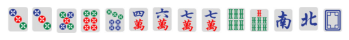

In [100]:
game_state = initialize_mahjong()
displayTiles(game_state, mahjong_dict)
getShangTingDistance(game_state)

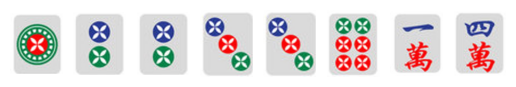

In [13]:
displayTiles(initialize_simple_mahjong(), simple_mahjong_dict)

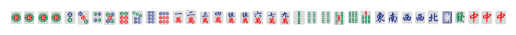

In [16]:
# to see if every image prints
test  = np.array([[1., 1., 1., 1.], # 1 tong
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.], # 9 tong
       [0., 1., 0., 0.], # 1 wan
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.], # 9 wan
       [0., 0., 0., 0.], # 1 suo
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.], # 9 suo
       [1., 0., 0., 0.], 
       [0., 0., 0., 1.],
       [1., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 1., 0., 1]])
displayTiles(test, mahjong_dict)